In [10]:
import os
import csv
from collections import defaultdict, Counter
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [11]:
LOGS = '/mnt/data0/lucy/gpt3_bias/logs/'
prompts_path = LOGS + 'original_prompts/'

## Character name popularity

In [3]:
def get_named_entities(char_neighbor_path): 
    '''
    Count named entities once per story
    '''
    named_people = Counter()
    for f in os.listdir(char_neighbor_path):
        all_people = set()
        with open(char_neighbor_path + f, 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            neighbor_dict = char_neighbors[char]
            for neighbor in neighbor_dict: 
                all_people.add(neighbor['character_name'])
                for al in neighbor['aliases']: 
                    all_people.add(al)
        for person in all_people: 
            name = '_'.join(person.split('_')[:-1])
            named_people[name] += 1
    return named_people

In [4]:
def plot_popular_names(char_neighbor_path, title): 
    plt.figure(dpi=150, figsize=(6,6))
    people = get_named_entities(char_neighbor_path)
    total_names = sum(list(people.values()))
    labels = []
    values = []
    for tup in people.most_common(20): 
        labels.append(tup[0])
        values.append(tup[1]/total_names)
    labels = labels[::-1]
    values = values[::-1]
    x = np.arange(len(labels))
    plt.barh(x, values, 0.7)
    plt.xlabel('Percentage of names')
    plt.title(title)
    plt.yticks(x, labels=labels, fontsize=12)
    plt.show()

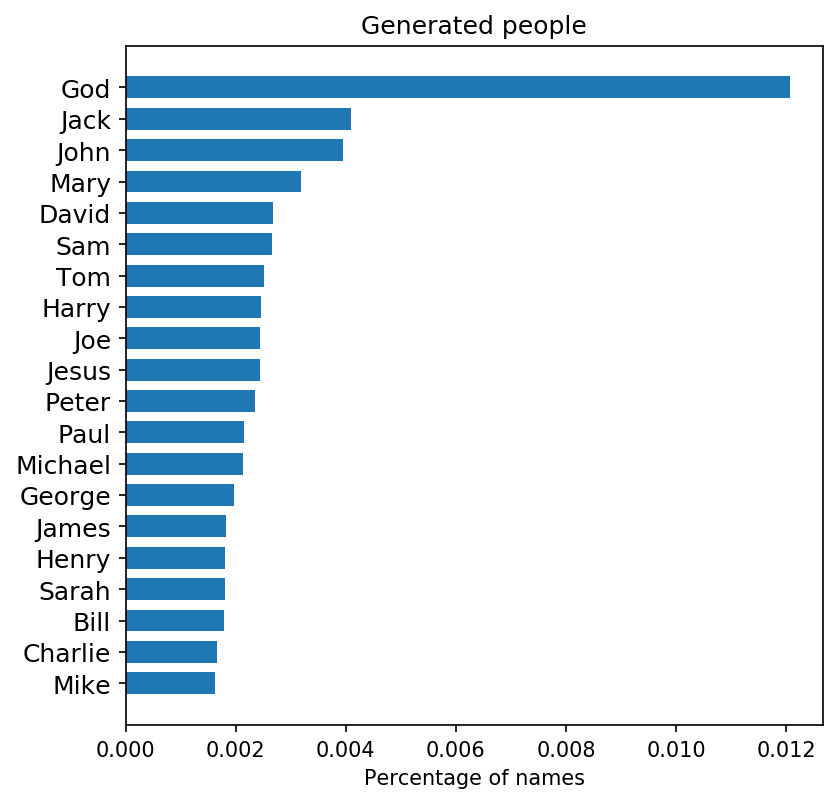

In [5]:
plot_popular_names(LOGS + 'char_neighbors_0.9/', 'Generated people')

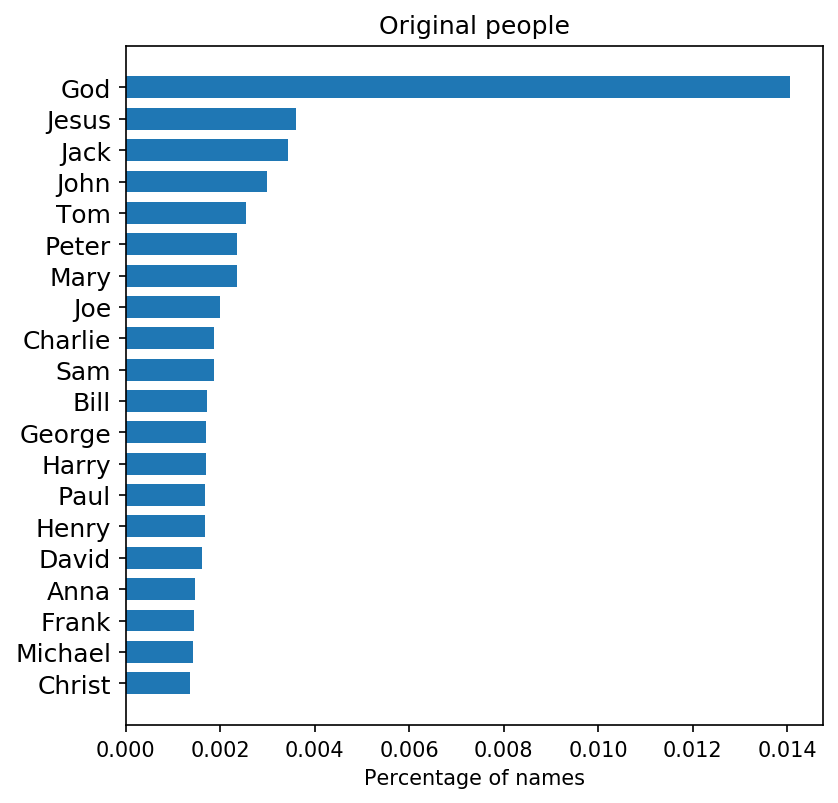

In [6]:
plot_popular_names(LOGS + 'orig_char_neighbors/', 'Original people')

## Character networks

In [35]:
def get_char_network(char_neighbor_path): 
    '''
    TODO: A main character's gender is based on each story, not all of them
    TODO: if a main character's gender in one story is unknown, generalize based on all of them
    '''
    d = {'main_gender':[], 'frac':[], 'neighbor_gender':[]}
    for title in os.listdir(prompts_path): 
        if not os.path.exists(char_neighbor_path + title + '.json'): continue
        with open(char_neighbor_path + title + '.json', 'r') as infile: 
            char_neighbors = json.load(infile)
        for char in char_neighbors: 
            # for every main character
            main_char_gender = defaultdict(str) # story ID to gender
            neighbor_dict = char_neighbors[char]
            neighbor_genders = defaultdict(list) # story ID to neighbor genders
            for neighbor in neighbor_dict: 
                # for every character it co-occurs with 
                gender = neighbor['gender_label']
                neighbor_n = neighbor['character_name']
                story_ID = int(neighbor_n.split('_')[-1])
                is_main = False
                if neighbor_n.startswith(char + '_'): 
                    # main character
                    is_main = True
                else: 
                    for al in neighbor['aliases']: 
                        if al.startswith(char + '_'): 
                            is_main = True
                if is_main: 
                    main_char_gender[story_ID] = gender
                    continue
                    
                neighbor_genders[story_ID].append(gender)
                
            for story_ID in main_char_gender: 
                main_g = main_char_gender[story_ID]
                n_genders = Counter(neighbor_genders[story_ID])
                total = sum(list(n_genders.values()))
                if total == 0: continue
                d['main_gender'].append(main_g)
                d['frac'].append(n_genders['other'])
                d['neighbor_gender'].append('other')
                d['main_gender'].append(main_g)
                d['frac'].append(n_genders['fem'])
                d['neighbor_gender'].append('fem')
                d['main_gender'].append(main_g)
                d['frac'].append(n_genders['masc'])
                d['neighbor_gender'].append('masc')
    return d

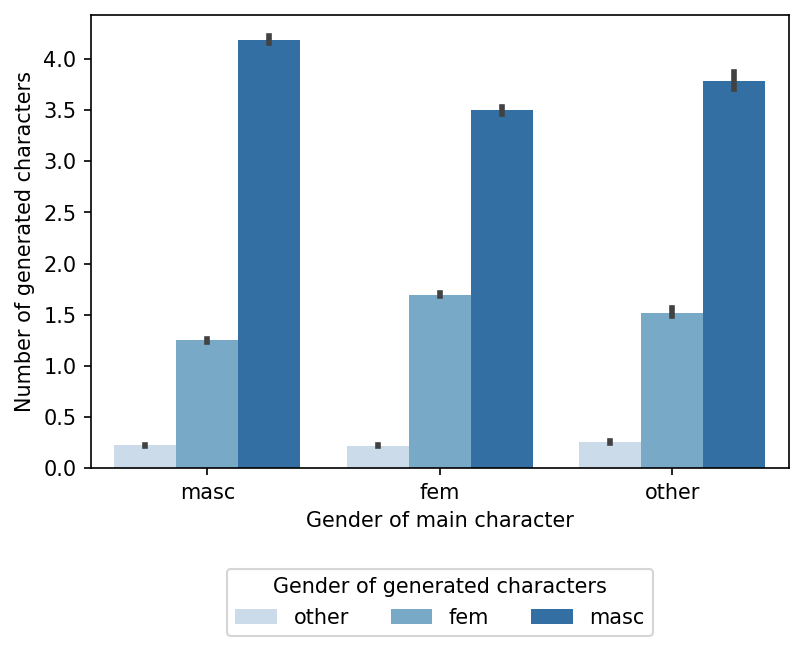

In [37]:
d = get_char_network(LOGS + 'char_gender_0.9/')
plt.figure(dpi=150)
sns.barplot(x="main_gender", y="frac", palette="Blues", hue="neighbor_gender", data=d, order=["masc", "fem", "other"])
plt.legend(title="Gender of generated characters", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xlabel("Gender of main character")
plt.ylabel("Number of generated characters")
plt.show()

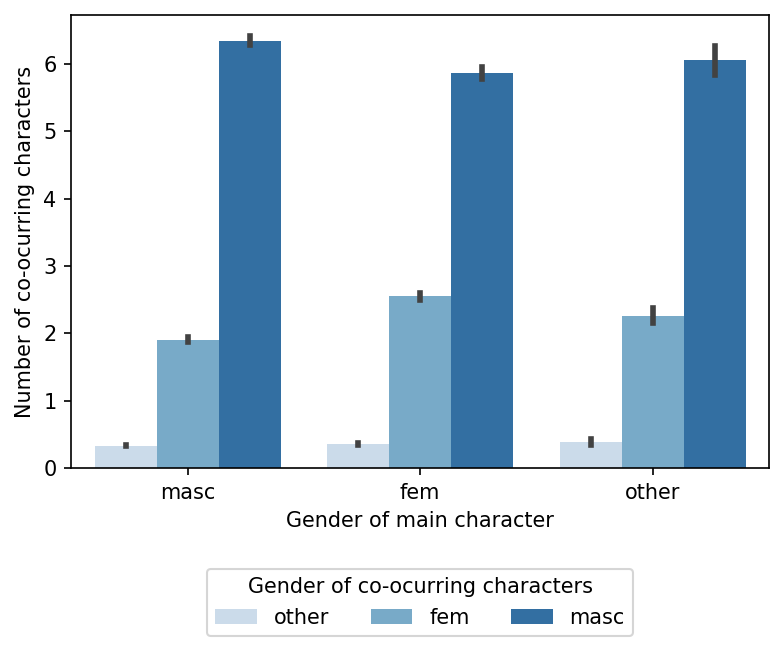

In [38]:
d = get_char_network(LOGS + 'orig_char_gender/')
plt.figure(dpi=150)
sns.barplot(x="main_gender", y="frac", palette="Blues", hue="neighbor_gender", data=d, order=["masc", "fem", "other"])
plt.legend(title="Gender of co-ocurring characters", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xlabel("Gender of main character")
plt.ylabel("Number of co-ocurring characters")
plt.show()

## Topics

In [39]:
def get_topic_by_dataset():
    topic_dir = LOGS + 'topics_0.9'
    doc_topic_file = '%s/doc-topics.gz' % topic_dir
    doc_topics = open(doc_topic_file).read().splitlines() # list of topics
    story_ids = open(topic_dir + '/story_id_order').read().splitlines() # story IDs 
    data_topics = {'dataset':[], 'topic':[], 'value':[]}
    for i, doc in enumerate(doc_topics): 
        contents = doc.split('\t')
        topics = [float(i) for i in contents[2:]]
        story_title_id = story_ids[i]             
        assert len(topics) == 50
        for topic_id, value in enumerate(topics): 
            if story_title_id.startswith('ORIG_'):
                data_topics['dataset'].append('original')
            else: 
                data_topics['dataset'].append('generated')
            data_topics['topic'].append(topic_id)
            data_topics['value'].append(value)
    return data_topics

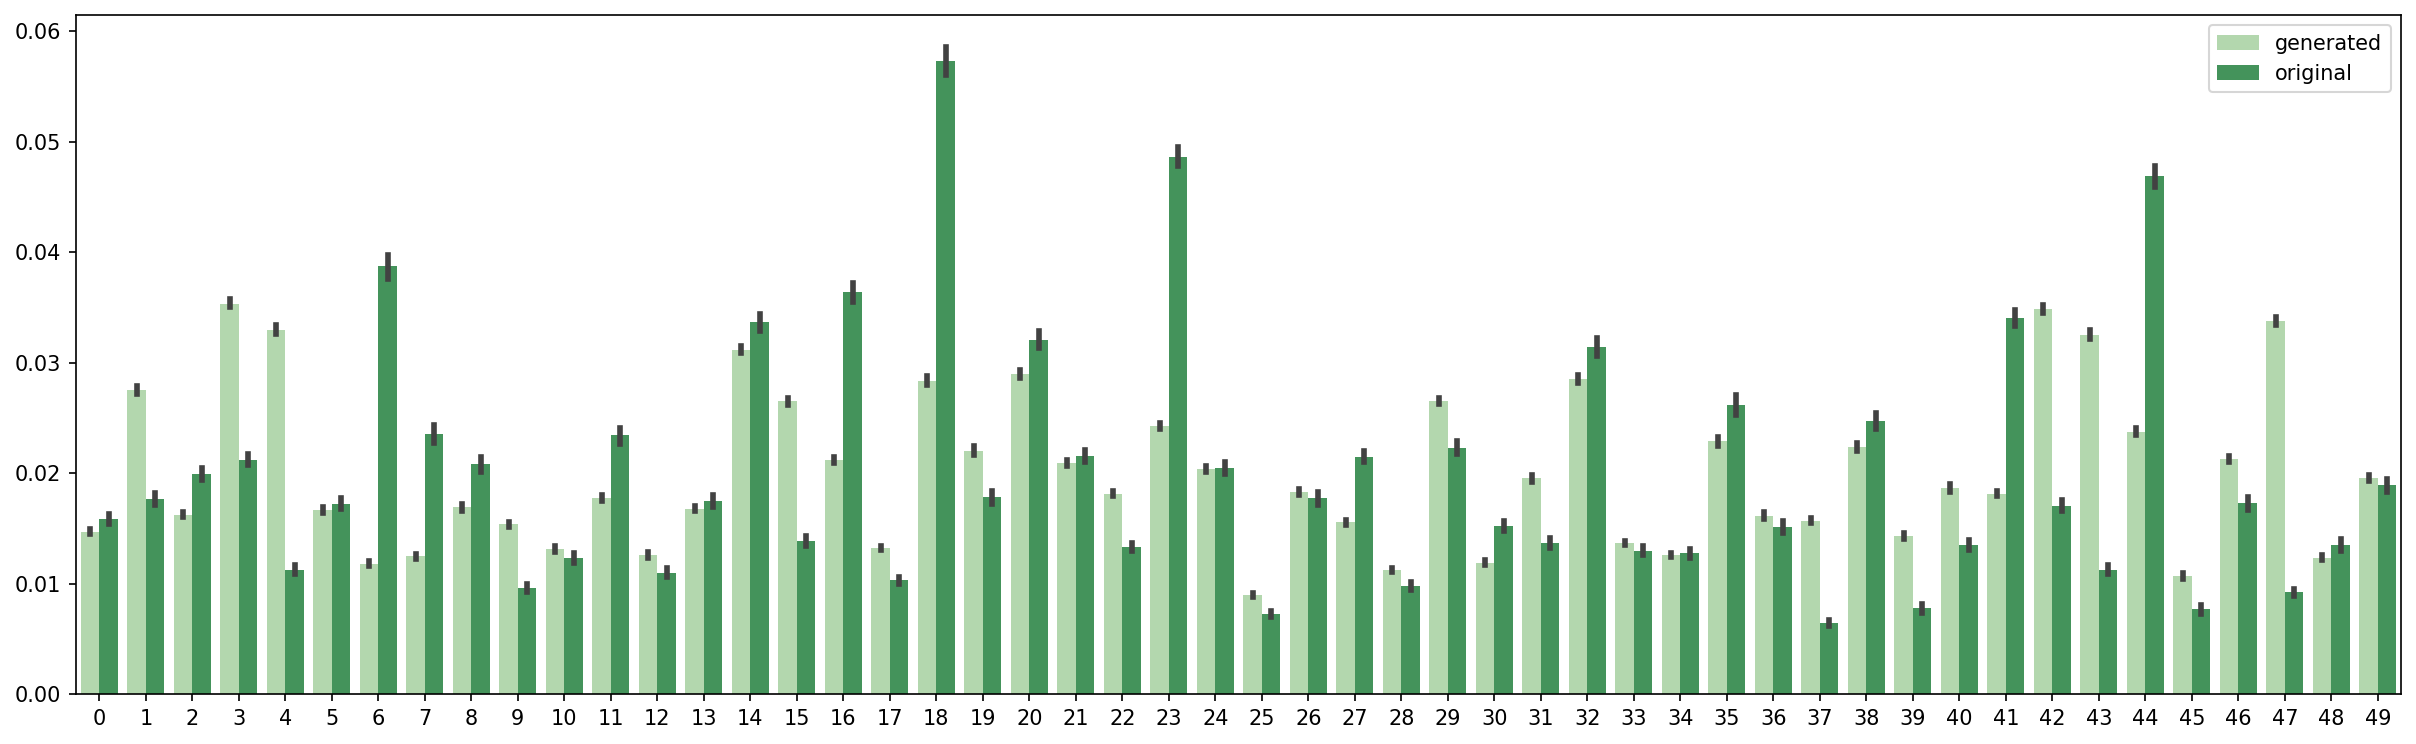

In [40]:
data_topics = get_topic_by_dataset()
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Greens", hue="dataset", data=data_topics)

In [41]:
with open(LOGS + 'gender_topics_0.9.json', 'r') as infile: 
    gen_gender_topics = json.load(infile)
with open(LOGS + 'orig_gender_topics.json', 'r') as infile: 
    orig_gender_topics = json.load(infile)

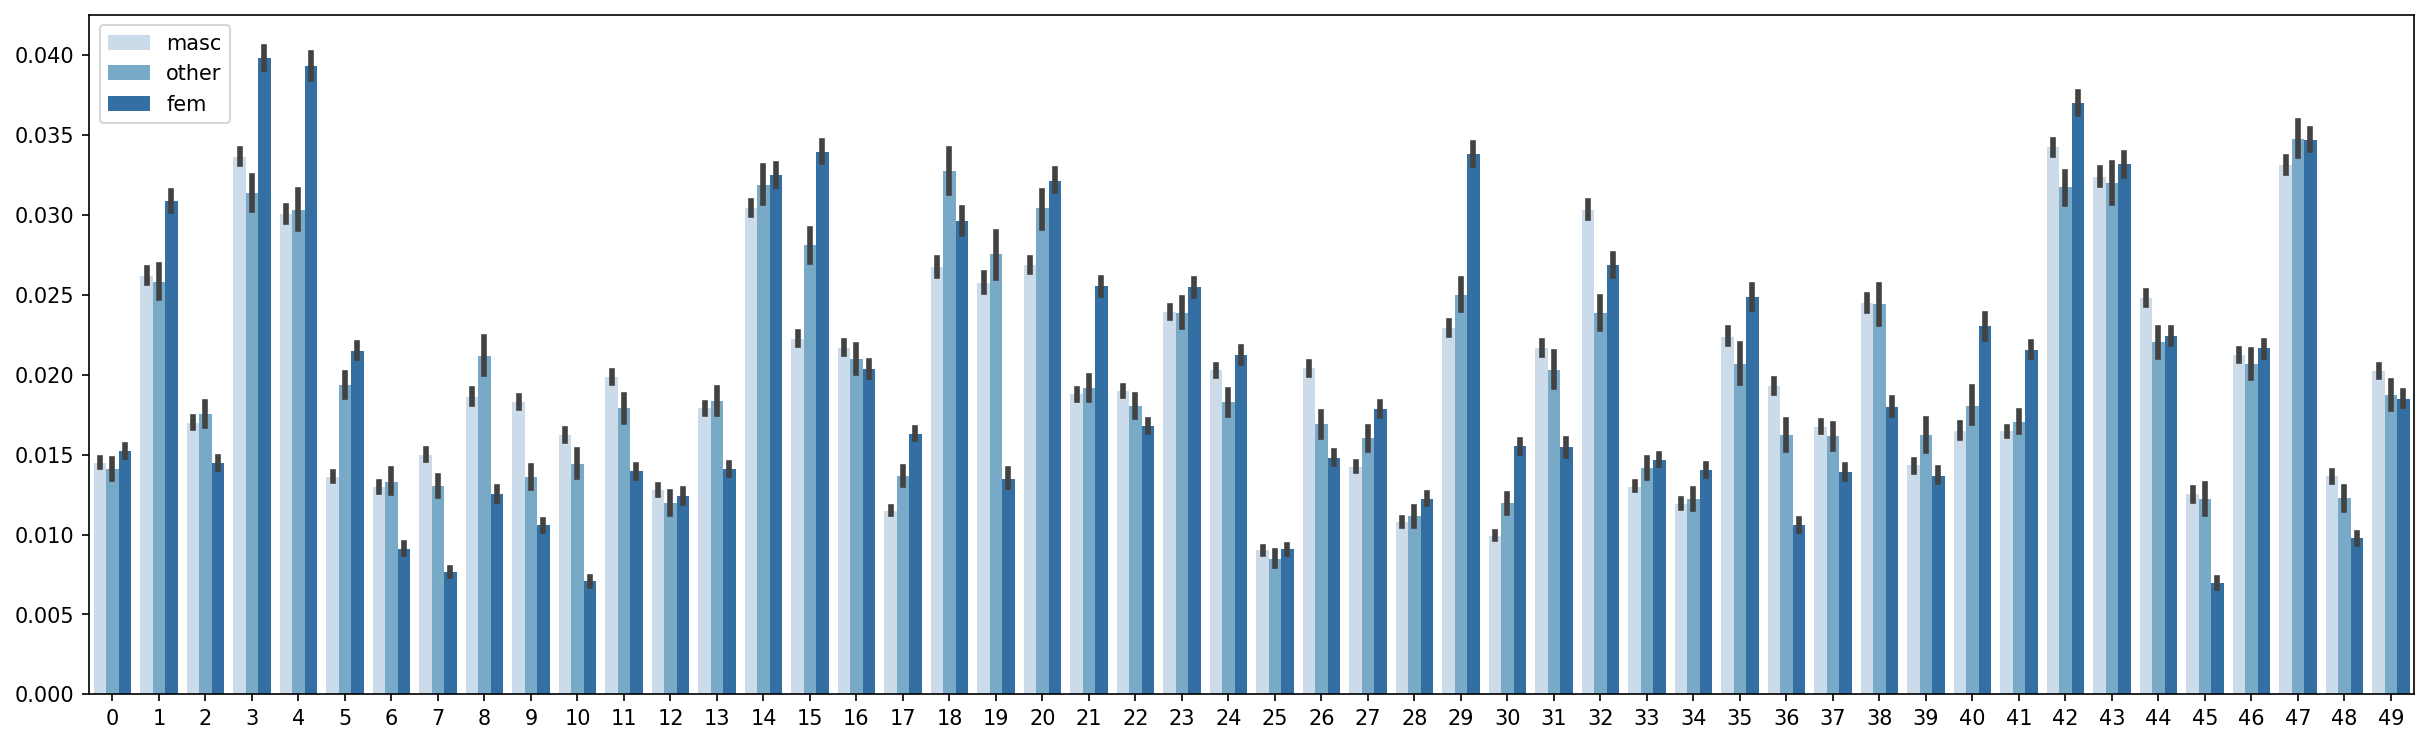

In [42]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=gen_gender_topics)

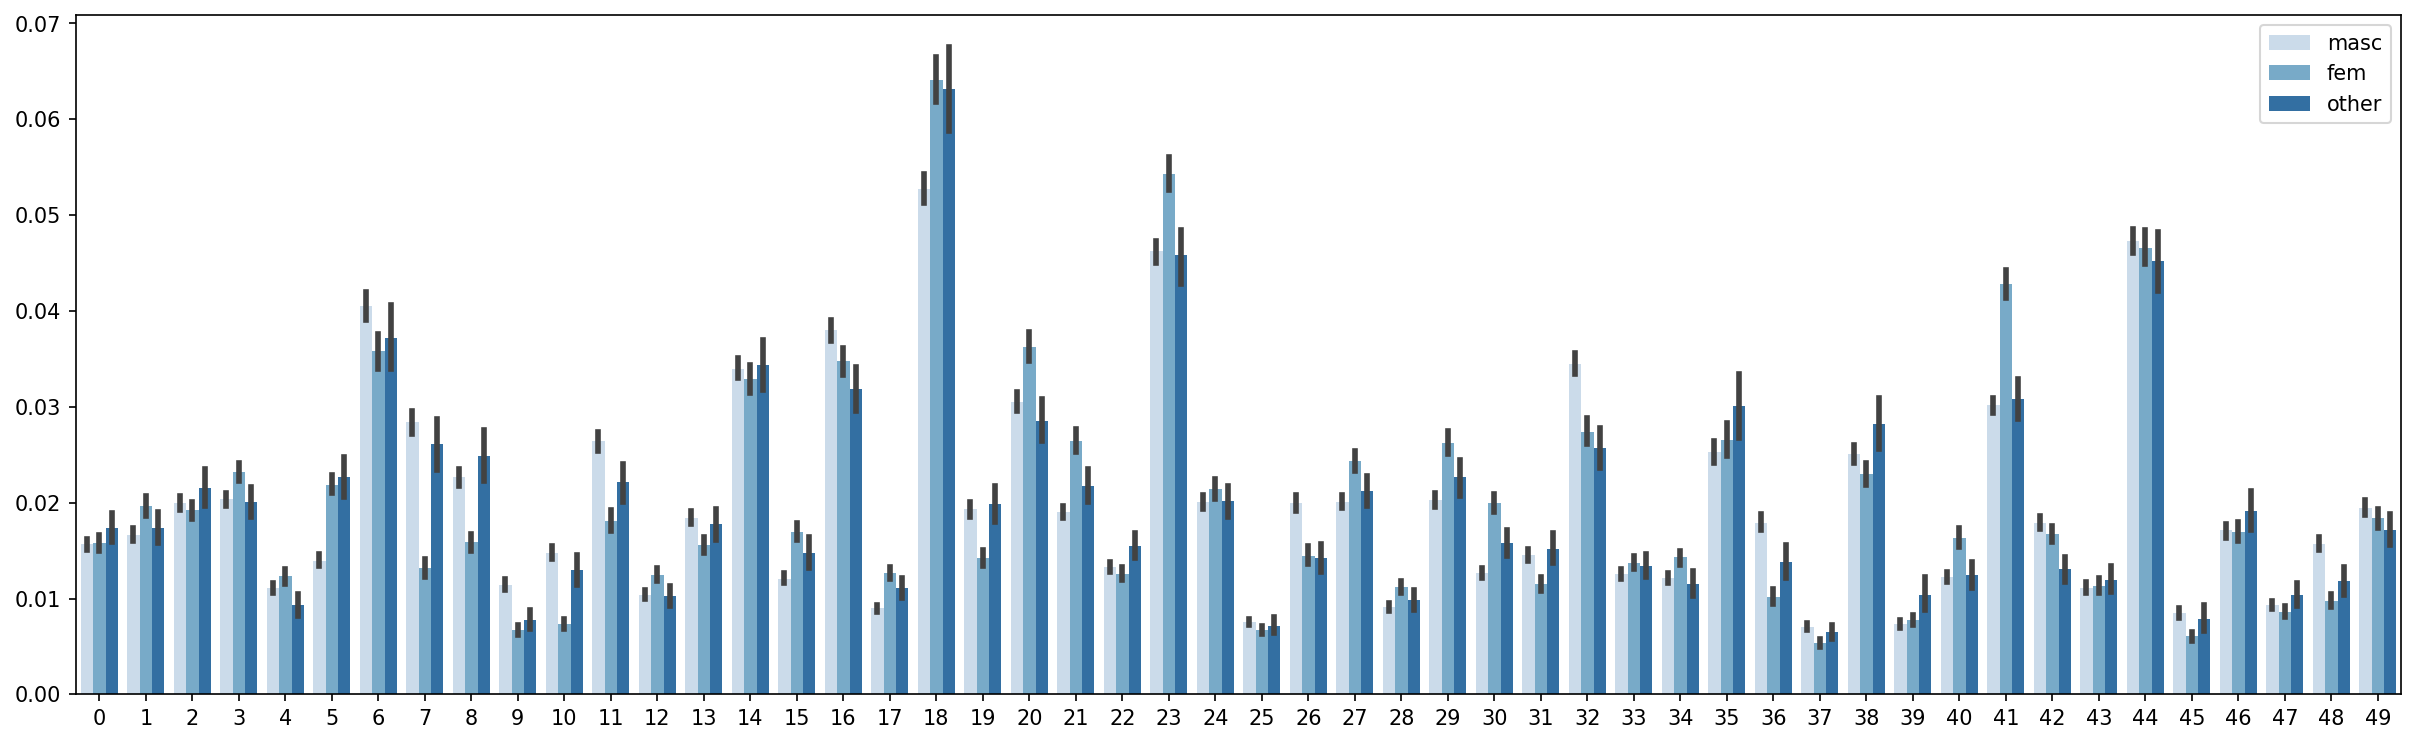

In [43]:
plt.figure(dpi=150, figsize=(20,6))
sns.barplot(x="topic", y="value", palette="Blues", hue="gender", data=orig_gender_topics)

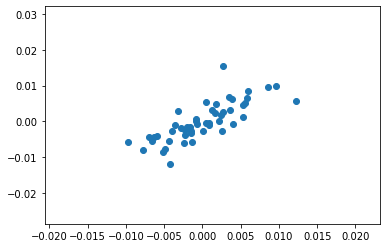

(0.7862434511042666, 1.327172712609583e-11)


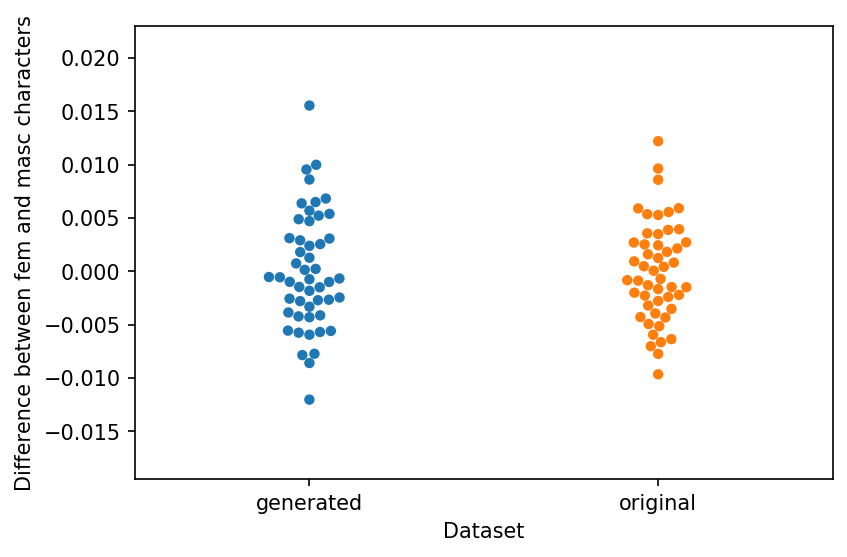

In [34]:
gender_df = pd.DataFrame(gen_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
diffs = {'dataset':[], 'diff':[], 'topic':[]}
gen_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('generated')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        gen_diffs[topic] = diff
gender_df = pd.DataFrame(orig_gender_topics)
gender_df = gender_df.groupby(['gender', 'topic']).mean()
gender_topic_dict = gender_df.to_dict('index')
orig_diffs = {}
for key in gender_topic_dict: 
    if key[0] == 'fem': 
        topic = key[1]
        fem_val = gender_topic_dict[key]['value']
        masc_val = gender_topic_dict[('masc', topic)]['value']
        diff = fem_val - masc_val
        diffs['dataset'].append('original')
        diffs['diff'].append(diff)
        diffs['topic'].append(topic)
        orig_diffs[topic] = diff
orig_diffs = [tup[1] for tup in sorted(orig_diffs.items(), key=lambda item: item[0])]
gen_diffs = [tup[1] for tup in sorted(gen_diffs.items(), key=lambda item: item[0])]
plt.scatter(orig_diffs, gen_diffs)
plt.show()
print(pearsonr(orig_diffs, gen_diffs))
plt.figure(dpi=150)
sns.swarmplot(x="dataset", y="diff", data=diffs)
plt.ylabel("Difference between fem and masc characters")
plt.xlabel("Dataset")
plt.show()

In [21]:
gender_df = pd.DataFrame.from_dict(gender_topics)

In [23]:
topic_29 = gender_df[gender_df['topic'] == 29]
#topic_29['value']
topic_29

,gender,topic,value
29,masc,29,0.274048
79,masc,29,0.274048
129,masc,29,0.274048
179,masc,29,0.274048
229,masc,29,0.274048
...,...,...,...
2324779,masc,29,0.274048
2324829,masc,29,0.274048
2324879,masc,29,0.274048
2324929,masc,29,0.274048
